# Project K-Means Algorithm

박유나 : 언어학과 2021-12659

임근영 : 항공우주공학과 2024-50067

In [76]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
from google.colab import files
uploaded = files.upload()

# Kmeans function

In [77]:
random.seed(1)

In [78]:
# 유클리디안 거리 구하기
def euclidean(x, y):
    dist = np.sqrt(np.sum((x - y)**2))
    return dist

# 각 point 별로 가까운 centroids에 따라 cluster 만들기
def cluster(centroids, points):
    cluster = list()
    for point in points:
        # 포인트와 각 centroid마다의 거리 구하기
        distance = [euclidean(point, centroid) for centroid in centroids] 
        # 거리가 가장 짧은 centroid(index)를 cluster에 추가하기
        cluster.append(np.argmin(distance))
    return np.array(cluster)

# cluster별 평균으로 새로운 centroids 구하기
def update_centorids(points, cluster, k):
    new_centroids = list()
    for i in range(k): # cluster 수 만큼 반복
        cluster_points = points[cluster == i] # 각 cluster에 속하는 포인트 선택
        if len(cluster_points) == 0: # cluster에 데이터가 하나도 없을 경우 랜덤으로 centroids를 만듦
            new_centroids.append(random.choice(list(points)))
        else: 
            # 각 cluster에 속하는 포인트의 평균으로 새로운 centroids 계산
            new_centroids.append(np.mean(cluster_points, axis=0)) 
    return np.array(new_centroids)

# kmeans 알고리즘
def kmeans(points, k, max_iter, initial = None, tol = 1e-4):
    # initial이 지정되지 않으면 주어진 데이터에서 k개 비복원추출
    if initial is None:
        initial = random.sample(list(points), k) # 파이썬의 random 알고리즘 사용
    
    # clustering하기
    centroids = initial
    iter = 0 # 언제 수렴하는지 알고자 추가
    for _ in range(max_iter):
        # 각 포인트 별로 가까운 centroids에 따라 cluster 만들기
        clusters = cluster(centroids, points) 
        # 각 cluster의 평균으로 새로운 centroids 구하기
        new_centroids = update_centorids(points, clusters, k)
        # stop criterion : 이전 centorids와 이후 centroids의 차가 tol 보다 작아지면 수렴이라 판단하고 반복 중지
        if np.all(abs(centroids - new_centroids) < tol):
            break
        centroids = new_centroids # centroids를 새로운 centroids로 업데이트
        iter+= 1 # 반복 횟수 1 증가
    return clusters, centroids, iter


# Task 1 : Toy problem

In [79]:
# 데이터 만들기
points = np.array([
    [2, 10], [2, 5], [8, 4], [5, 8],
    [7, 5], [6, 4], [1, 2], [4, 9]
])

initial_centroids = np.array([
    [2, 10],  
    [5, 8],   
    [1, 2]   
])

Clusters: [0 2 1 0 1 1 2 0]
Final Centroids: [[3.66666667 9.        ]
 [7.         4.33333333]
 [1.5        3.5       ]]
Iterations: 3


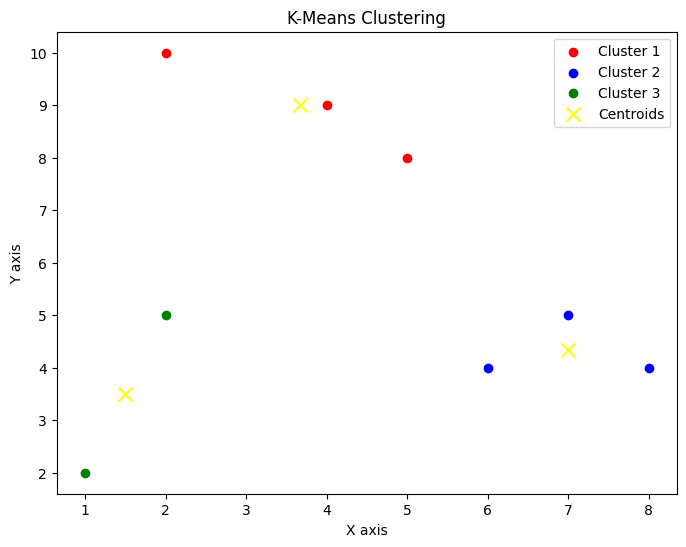

In [96]:
# k means 알고리즘 실시하기
clusters, final_centroids, iterations = kmeans(points, initial=initial_centroids, max_iter=100, k=3)

print("Clusters:", clusters)
print("Final Centroids:", final_centroids)
print("Iterations:", iterations)

# 시각화
plt.figure(figsize=(8, 6))

# 색상 팔레트 만들기
colors = ['r', 'b', 'g']

# 각 클러스터 별로 색을 다르게 지정
for i in range(3):
    cluster_points = points[clusters == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], label=f'Cluster {i+1}')
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], c='yellow', marker='x', s=100, label='Centroids')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()
plt.title('K-Means Clustering')
plt.show()


# Task 2 : Open-ended Problem

In [81]:
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing

In [82]:
# 데이터 불러오기
territory_file = 'South_Korea_territory.csv'
territory = pd.read_csv(territory_file)

# Extract longitude and latitude
longitude = territory['Longitude (deg)']
latitude = territory['Latitude (deg)']

In [83]:
# territory 시각화
ring = LinearRing(list(zip(longitude, latitude)))
polygon = Polygon(ring)

# territory 내부에 무작위 점 생성
def generate_random_points(polygon, num_points):
    min_x, min_y, max_x, max_y = polygon.bounds
    points = []
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if polygon.contains(random_point):
            points.append(random_point)
    return points

Silhouette score: 0.3742377362311307


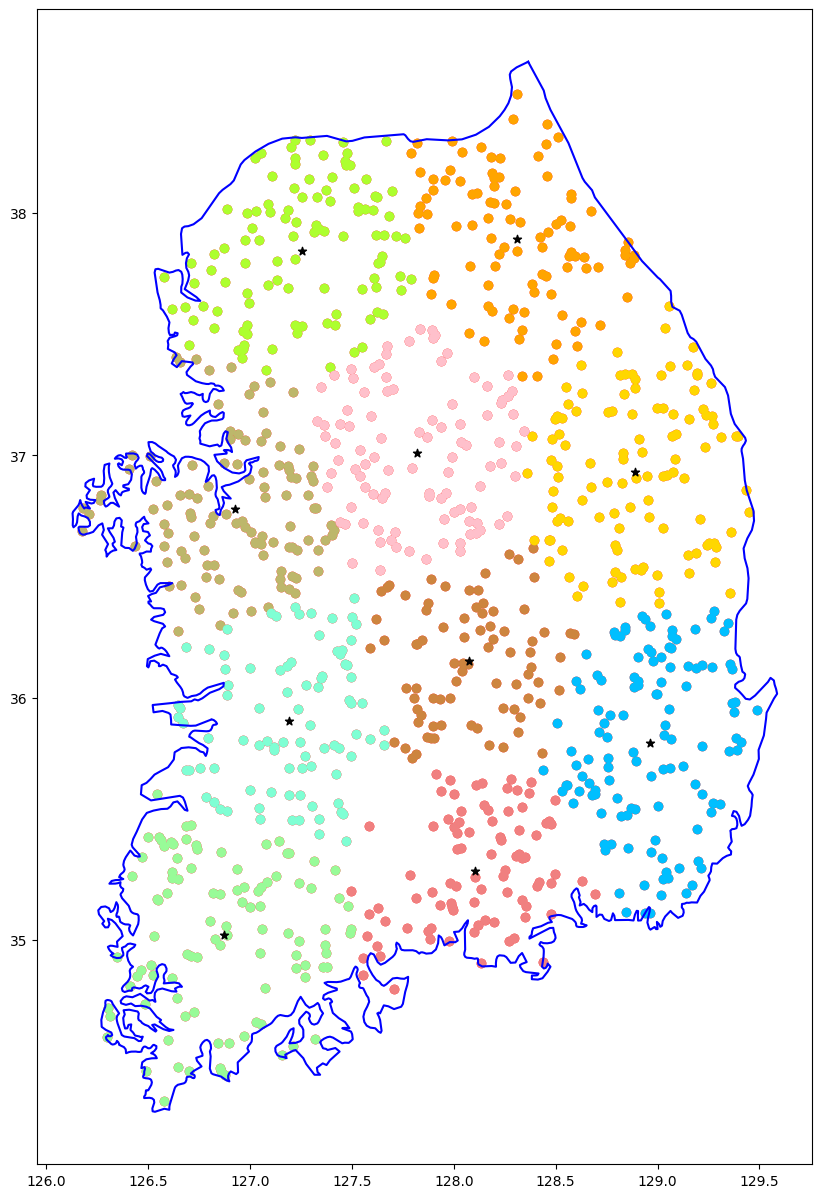

In [84]:
##### 주요 parameter 결정
number_of_point = 1000 # 점 개수
iter = 100 # 반복횟수
#####

random_points = generate_random_points(polygon, number_of_point) # 랜덤 포인트 생성
centroid_point = generate_random_points(polygon, k)  # 초기 centroid point 지정

# point 리스트를 배열로 변경
random_points = np.array([[point.x, point.y] for point in random_points])
centroid_point = np.array([[point.x, point.y] for point in centroid_point])

# kmeans clustering 
clusters, centroids, iterations = kmeans(random_points, 10, iter, initial=centroid_point)

## silhouette score, 10개의 sample말고 몇 개의 sample로 k-means를 하는 것이 효과적인가
shilhouette_score = silhouette_score(random_points, clusters)
print('Silhouette score:', shilhouette_score)

# 데이터 시각화
plt.figure(figsize=(10, 15))
plt.scatter([point[0] for point in random_points], [point[1] for point in random_points], color='red')
plt.plot(*ring.xy, color='blue')

# 클러스터 별로 색으로 구분
colors = ['lightcoral', 'peru', 'orange', 'gold', 'darkkhaki', 'greenyellow', 'palegreen', 'aquamarine', 'deepskyblue', 'pink']
for i in range(k):
    cluster_points = random_points[clusters == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i])
    
plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='*')
plt.show()

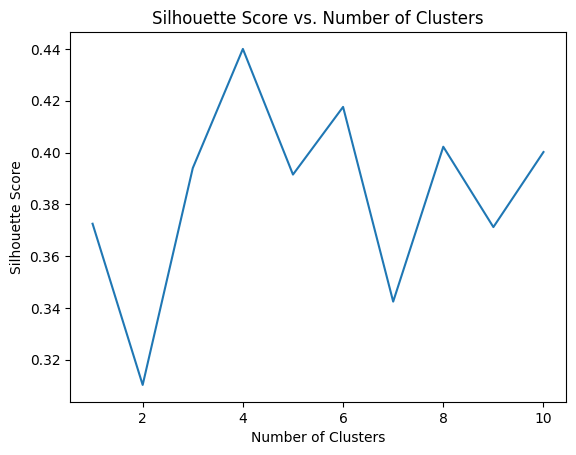

Silhouette score: [0.3724986356475889, 0.3102284502202757, 0.3939886966333805, 0.44003411252194014, 0.3914962397327335, 0.41763417123181124, 0.3424150524060982, 0.4022468502556935, 0.3712050188584708, 0.40020320950878363]


In [94]:
##### 주요 parameter 결정
number_of_point = 50  # 점 개수
iter = 100  # 반복횟수
k = 10  # cluster 개수
#####
silhouette_score_list = []

for g in range(k):
  random_points = generate_random_points(polygon, number_of_point)
  centroid_point = generate_random_points(polygon, k)  # 초기 centroid point 지정

  # point 리스트를 배열로 변경
  random_points = np.array([[point.x, point.y] for point in random_points])
  centroid_point = np.array([[point.x, point.y] for point in centroid_point])

  # kmeans clustering
  clusters, centroids, iterations = kmeans(random_points, k, max_iter = iter, initial=centroid_point)
    
  # 실루엣 점수 계산
  score = silhouette_score(random_points, clusters)
  silhouette_score_list.append(score)
    

plt.plot(range(1, k + 1), silhouette_score_list)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

print('Silhouette score:', silhouette_score_list)



# Task 3 : Real-world Problem(i.e., Vertiport Placement)

## Clustering

In [69]:
# 데이터 불러오기
vertiport_candidates = pd.read_csv('Vertiport_candidates.csv')
south_korea_territory = pd.read_csv('South_Korea_territory.csv')

print(vertiport_candidates.head())
print(south_korea_territory.head())


   Longitude (deg)  Latitude (deg)
0       126.940197       37.621876
1       127.096292       37.535756
2       126.939432       37.492020
3       127.033749       37.612760
4       126.839673       37.561111
   Longitude (deg)  Latitude (deg)
0       128.364919       38.624335
1       128.394784       38.578074
2       128.441417       38.505805
3       128.450694       38.474107
4       128.474457       38.426093


In [115]:
coordinates = vertiport_candidates[['Latitude (deg)', 'Longitude (deg)']].values
num_clusters = 17

# kmeans 알고리즘 실시하기
clusters, final_centroids, iterations  = kmeans(k=num_clusters, max_iter = 100, 
                                                initial= None, points = coordinates, tol = 1e-4)
print("Clusters:", clusters)
print("Final Centroids:", final_centroids)
print("Iterations:", iterations)


Clusters: [5 5 5 ... 9 9 9]
Final Centroids: [[ 37.29153823 127.48162439]
 [ 37.79345132 127.35235455]
 [ 36.28976283 127.4778338 ]
 [ 37.88662478 126.9316216 ]
 [ 37.38961221 128.68338789]
 [ 37.54402536 127.02819114]
 [ 35.96118538 126.77602665]
 [ 36.53520621 129.02940193]
 [ 35.31724455 128.00078798]
 [ 34.72322345 126.78986549]
 [ 37.50007047 126.74897414]
 [ 36.9171189  126.68589938]
 [ 35.85681049 128.56714398]
 [ 35.22508823 128.97511764]
 [ 36.8422553  128.03070805]
 [ 37.09153485 127.09407103]
 [ 35.4578539  129.2189276 ]]
Iterations: 13


In [116]:
# cluster 별 데이터 포인트 개수 
import collections
x = collections.Counter(clusters)
collections.OrderedDict(sorted(x.items()))

OrderedDict([(0, 512),
             (1, 542),
             (2, 447),
             (3, 417),
             (4, 191),
             (5, 1457),
             (6, 414),
             (7, 184),
             (8, 435),
             (9, 534),
             (10, 719),
             (11, 145),
             (12, 495),
             (13, 477),
             (14, 182),
             (15, 312),
             (16, 311)])

C:\Users\YUNA\AppData\Local\Temp\ipykernel_24648\383378292.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_points[:, 1], cluster_points[:, 0], c=colors[i % len(colors)], s=10, label=f'Cluster {i + 1}')


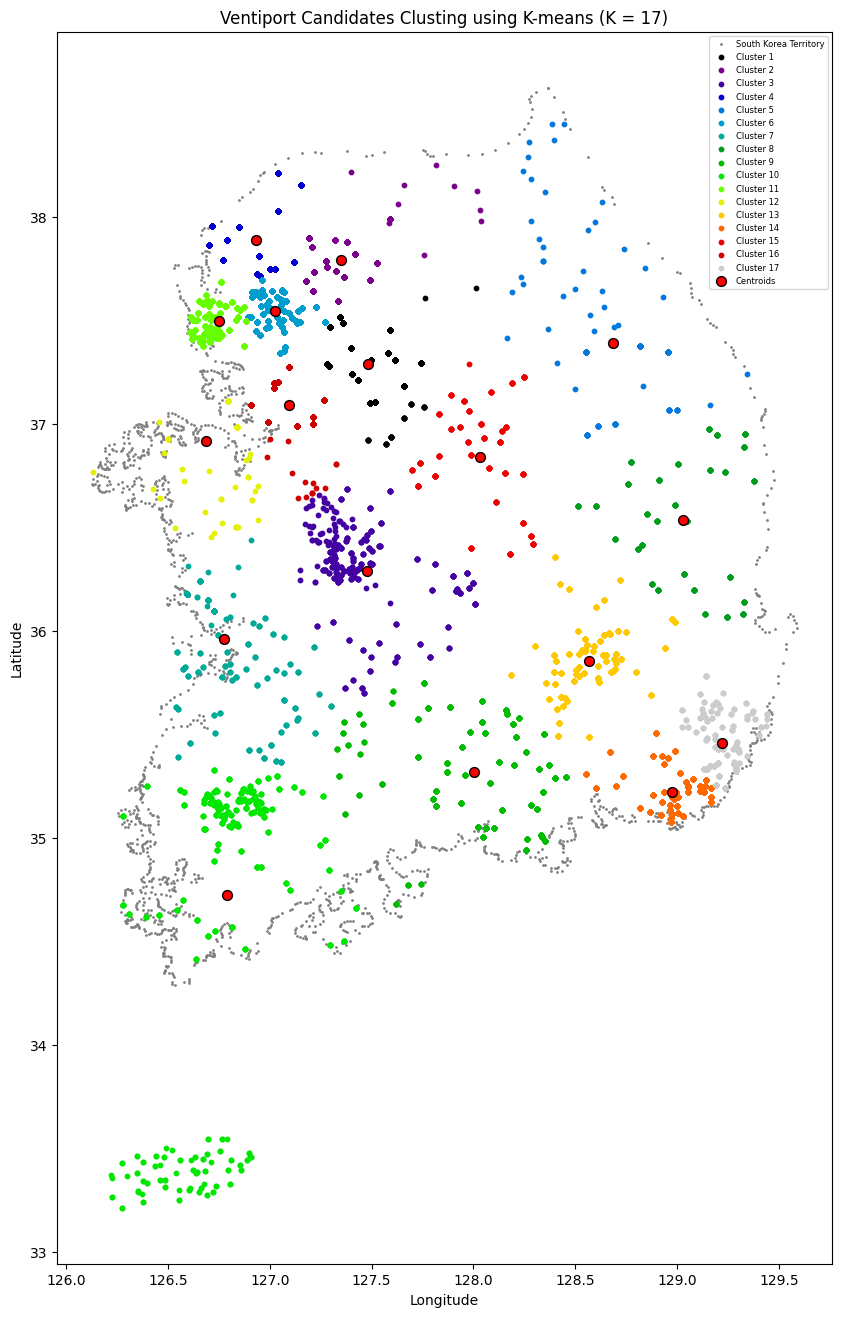

In [117]:
# 시각화
plt.figure(figsize=(10, 16))

# 대한민국 영토 그리기
plt.scatter(south_korea_territory['Longitude (deg)'], south_korea_territory['Latitude (deg)'], c='gray', s=1, label='South Korea Territory')

# 색상팔레트 만들기
colors = cm.nipy_spectral(np.linspace(0, 1, len(np.unique(clusters))))


# 클러스터 별로 색을 다르게 해서 vertiport 후보지들 표기하기
for i in range(len(final_centroids)):
    cluster_points = coordinates[clusters == i]
    plt.scatter(cluster_points[:, 1], cluster_points[:, 0], c=colors[i % len(colors)], s=10, label=f'Cluster {i + 1}')

plt.scatter(final_centroids[:, 1], final_centroids[:, 0], c='red', s=50, marker='o', label='Centroids', edgecolors= 'black')


plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(prop={'size': 6})
plt.title('Ventiport Candidates Clusting using K-means (K = 17)')
plt.show()




### Using Transportation Information

In [118]:
# 기차역과 공항 데이터 파일 로드
station = pd.read_excel('Train_station.xlsx')
airport = pd.read_excel('Airport.xlsx')

# 데이터 확인
print(vertiport.head())
print(station.head())

# 데이터 불러오기
territory_longitude = south_korea_territory['Longitude (deg)']
territory_latitude = south_korea_territory['Latitude (deg)']
vertiport_longitude = vertiport_candidates['Longitude (deg)']
vertiport_latitude = vertiport_candidates['Latitude (deg)']
station_longitude = station['Longitude']
station_latitude = station['Latitude']
airport_longitude = airport['Longitude']
airport_latitude = airport['Latitude']

   Longitude (deg)  Latitude (deg)
0       126.940197       37.621876
1       127.096292       37.535756
2       126.939432       37.492020
3       127.033749       37.612760
4       126.839673       37.561111
    Longitude   Latitude Unnamed: 2
0  126.834059  37.611846        행신역
1  126.972317  37.555946        서울역
2  126.884789  37.416522        광명역
3  127.001461   37.26676        수원역
4  127.104561  36.794607      천안아산역


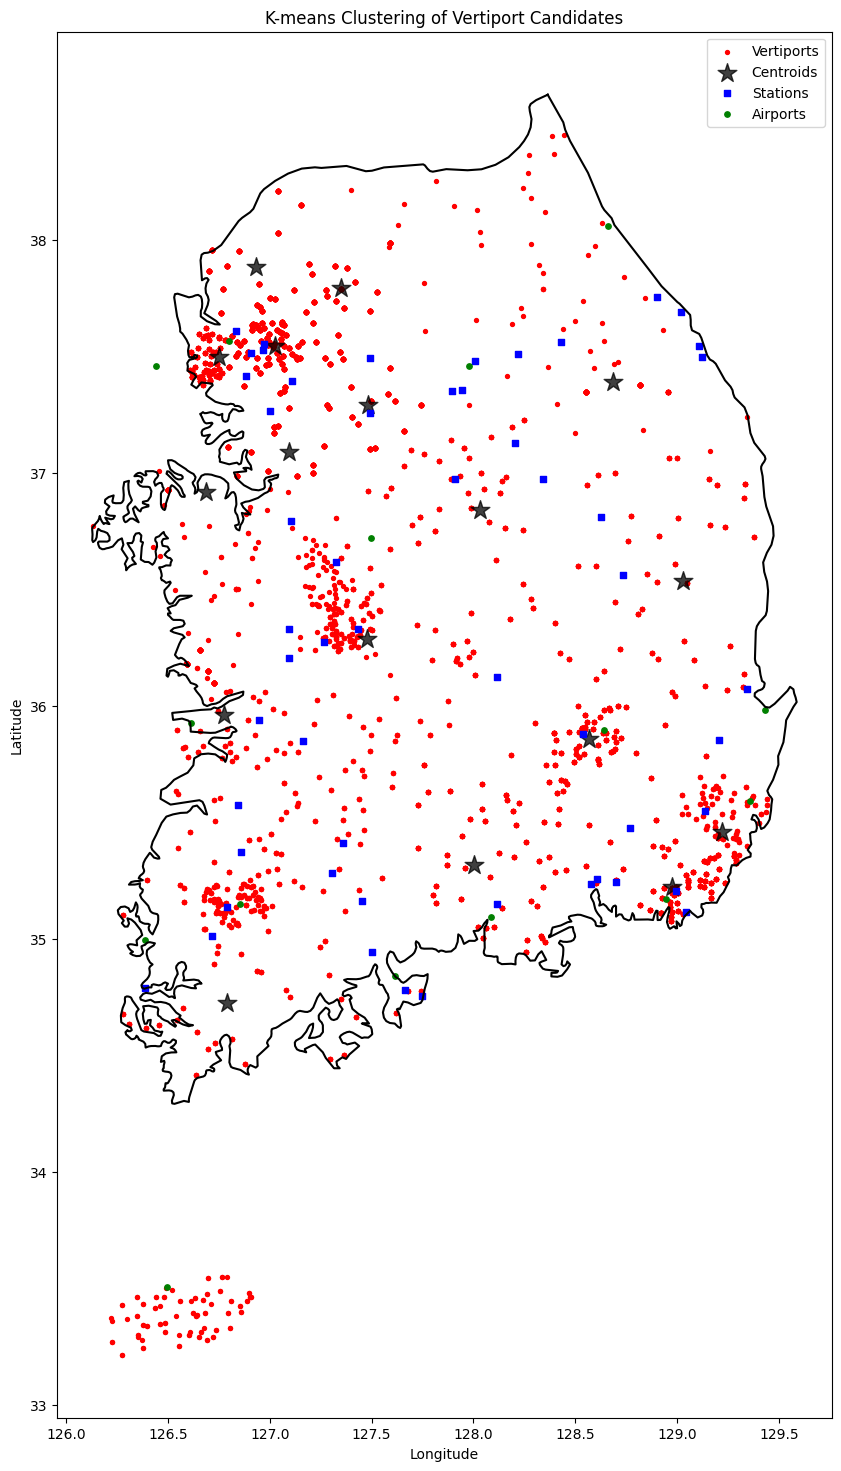

In [119]:
# 시각화
ring = LinearRing(list(zip(territory_longitude, territory_latitude)))
polygon = Polygon(ring)
plt.figure(figsize=(10, 18))

# 클러스터 할당된 데이터 포인트

plt.scatter(vertiport_longitude, vertiport_latitude, color='red', s=8, label='Vertiports')
plt.scatter(final_centroids[:, 1], final_centroids[:, 0], c='black', s=200, alpha=0.75, marker='*', label='Centroids')
plt.scatter(station_longitude, station_latitude, color='blue', s=15, marker='s', label='Stations')
plt.scatter(airport_longitude, airport_latitude, color='green', s=15, marker='o', label='Airports')

# 영토 경계
plt.plot(*ring.xy, color='black')

# 범례 추가
plt.legend()
plt.title('K-means Clustering of Vertiport Candidates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 시각화 보여주기
plt.show()

## Evaluaion

### sillhouette score function

In [176]:
def silhouette(points, clusters):
    sillhouette_list = list()  # 각 데이터 포인트의 실루엣 스코어를 저장할 리스트를 초기화
    k = len(np.unique(clusters))  # 클러스터의 수
    
    # 각 데이터 포인트에 대해 반복
    for i in range(len(points)):
        # 같은 클러스터에 속하는 데이터 포인트를 구하는데, 본인은 제외
        same_cluster = points[(clusters == clusters[i]) & (np.arange(len(points)) != i)]
        
        # 다른 클러스터에 속하는 데이터 포인트들을 저장할 리스트를 초기화
        other_cluster = list()
        for j in range(k):
            if j != clusters[i]:
                # 각 클러스터마다 현재의 데이터 포인트와 다른 클러스터에 속하는 데이터 포인트들을 구한다.
                other_cluster.append(points[clusters == j])
        
        # 같은 클러스터에 데이터 포인트가 하나도 없으면 실루엣 스코어를 0으로 설정
        if len(same_cluster) == 0:
            sillhouette_list.append(0)
        
        else:
            # ai 계산: 같은 클러스터의 데이터 포인트들과의 평균 거리를 계산
            same_dist = list()
            for same in same_cluster:
                same_dist.append(euclidean(points[i], same))
            ai = np.mean(same_dist)
            
            # bi 계산: 다른 클러스터의 데이터 포인트들과의 평균 거리를 계산하고, 그 중 가장 작은 값을 선택
            bi_list = list()
            for cluster in other_cluster:
                other_dist = list()
                for other in cluster:
                    other_dist.append(euclidean(points[i], other))
                bi_list.append(np.mean(other_dist))
            bi = min(bi_list) # 여러 클러스터내의 평균 거리중 가장 작은 값을 선택
            
            # 공식에 따라 실루엣 점수를 계산
            sillhouette_list.append((bi - ai) / max(bi, ai))
    
    # 모든 데이터 포인트의 실루엣 스코어의 평균을 구함
    sillhouette_score = np.mean(sillhouette_list)

    return sillhouette_list, sillhouette_score
        

In [177]:
# 실루엣 점수 구하는 함수를 이용한 실루엣 점수
clusters, final_centroids, iterations = kmeans(points, initial=initial_centroids, max_iter=100, k=3)
sillhouette_list, average = silhouette(points, clusters)
print(average)
print(sillhouette_list)

0.5708086620582917
[0.552786404500042, 0.30827652333975814, 0.7424971893898715, 0.4084491934010904, 0.7293650714171926, 0.6409217021623088, 0.510318556506094, 0.6738546557499759]


In [178]:
from sklearn.metrics import silhouette_score, silhouette_samples
# sklearn 라이브러리의 silhouette_score
print(silhouette_score(points, clusters))
silhouette_samples(points, clusters)

0.5708086620582917


array([0.5527864 , 0.30827652, 0.74249719, 0.40844919, 0.72936507,
       0.6409217 , 0.51031856, 0.67385466])

In [191]:
clusters, final_centroids, iterations = kmeans(k=num_clusters, max_iter = 100, initial= None,
                                                points = coordinates, tol = 1e-4)
print("Clusters:", clusters)
print("Final Centroids:", final_centroids)
print("Iterations:", iterations)

Clusters: [ 0  4 15 ...  5  5  5]
Final Centroids: [[ 37.64465769 127.00808037]
 [ 36.9261164  128.80424909]
 [ 37.918917   127.41499966]
 [ 36.95546435 126.76930672]
 [ 37.48692352 127.06050788]
 [ 34.75074029 126.83572602]
 [ 37.42127212 126.74136621]
 [ 37.60732257 127.32493645]
 [ 35.60000508 128.36090397]
 [ 35.3597143  129.08635014]
 [ 36.22020804 127.49313774]
 [ 37.10933045 127.74632407]
 [ 35.97551685 126.76501788]
 [ 37.94073609 126.85734016]
 [ 37.15318989 127.20128421]
 [ 37.55641577 126.88010236]
 [ 37.51665846 126.67647281]]
Iterations: 14


In [181]:
sillhouette_list, average = silhouette(coordinates, clusters)
print(average)
print(sillhouette_list)

0.441120961875548
[0.5756027704808483, 0.3637934425231505, 0.13021803210421312, 0.4179043363344609, 0.2773908825861443, 0.49970026257135874, -0.10523103302548885, 0.48348295437111627, 0.25133606626398886, 0.28325514412164543, 0.3621111922201391, -0.033425298900032006, 0.29148712254446113, 0.40616133426857953, 0.3754444968704115, 0.4460107610840655, 0.38238139362800344, 0.5378363058863792, 0.17201251534435708, 0.09645980676144764, 0.11939325771831169, 0.5703298688493045, 0.5790127249155596, -0.06558018050706536, 0.00871845046886381, 0.33353256228619793, 0.2808563579979901, 0.3420968225836215, -0.039764388522688494, 0.2673311662594733, 0.4396700008710396, 0.34333613786060213, 0.4517411323094885, 0.2399511873348089, 0.6207006991947074, 0.5146758046194531, 0.4868577230815873, 0.20805109016534587, 0.43417689548088834, 0.44857733972766317, 0.47277760123862295, 0.1398597767619916, 0.2450014299982057, 0.5977467598450803, -0.02909177023994719, 0.5568789647619736, 0.34654729791460437, 0.00678743

In [182]:
print(silhouette_score(coordinates, clusters))
silhouette_samples(coordinates, clusters)

0.4411209373872431


array([0.57560277, 0.36379344, 0.13021803, ..., 0.42329766, 0.39051706,
       0.3809257 ])

sklearn의 silhouette_score 함수와 값이 같은 것을 확인 하였다. 즉, 구현한 silhouette 함수가 실루엣 스코어를 잘 계산함을 의미한다.
다만 연산 시간의 측면에서 sklearn의 silhouette_score 함수가 효과적이므로
최적 k를 찾기 위한 silhoutte_score를 계산하기 위한 이후의 코드에서는 silhouette_score 함수를 사용할 것이다.


### elbow method

In [44]:
def calculate_sse(points, clusters, centroids):
    sse = 0
    for i in range(len(centroids)):
         # 현재 클러스터 i에 속하는 데이터 포인트를 선택
        cluster_points = points[clusters == i]
        # 클러스터 i의 중심점과 각 데이터 포인트 간의 거리의 제곱을 계산하여 sse를 구함
        sse += np.sum([euclidean(point, centroids[i]) ** 2 for point in cluster_points])
    return sse

For n_clusters = 5 SSE = 1719.4721922687486
For n_clusters = 10 SSE = 947.7110943855582
For n_clusters = 15 SSE = 485.4642223963629
For n_clusters = 20 SSE = 566.8309599226565
For n_clusters = 25 SSE = 303.66902305863016
For n_clusters = 30 SSE = 242.8112265316132
For n_clusters = 35 SSE = 187.4592692250831
For n_clusters = 40 SSE = 219.35865243007822
For n_clusters = 45 SSE = 189.45762879464223
For n_clusters = 50 SSE = 159.44531472026964


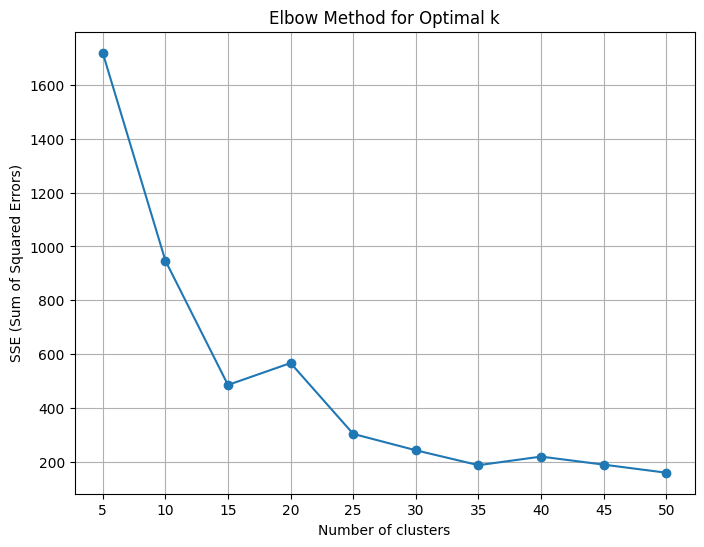

In [50]:
range_n_clusters = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
elbow = list()
for n_clusters in range_n_clusters:
    clusters, final_centroids, iterations  = kmeans(k=n_clusters, max_iter = 100, initial= None, points = coordinates, tol = 1e-4)
    sse = calculate_sse(coordinates, clusters, final_centroids)
    elbow.append(sse)
    print(
        "For n_clusters =",
        n_clusters,
        "SSE =",
        sse,
    )

# 결과 시각화
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, elbow, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

### silhouet method

k에 따른 실루엣 스코어 비교를 위한 시각화 코드는 https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html 을 참고하였다.

For n_clusters = 25 The average silhouette_score is : 0.43202351262147803
For n_clusters = 26 The average silhouette_score is : 0.4473416210026698
For n_clusters = 27 The average silhouette_score is : 0.43234606048666335
For n_clusters = 28 The average silhouette_score is : 0.4470269991788101
For n_clusters = 29 The average silhouette_score is : 0.43357405118170833
For n_clusters = 30 The average silhouette_score is : 0.42958050349814164


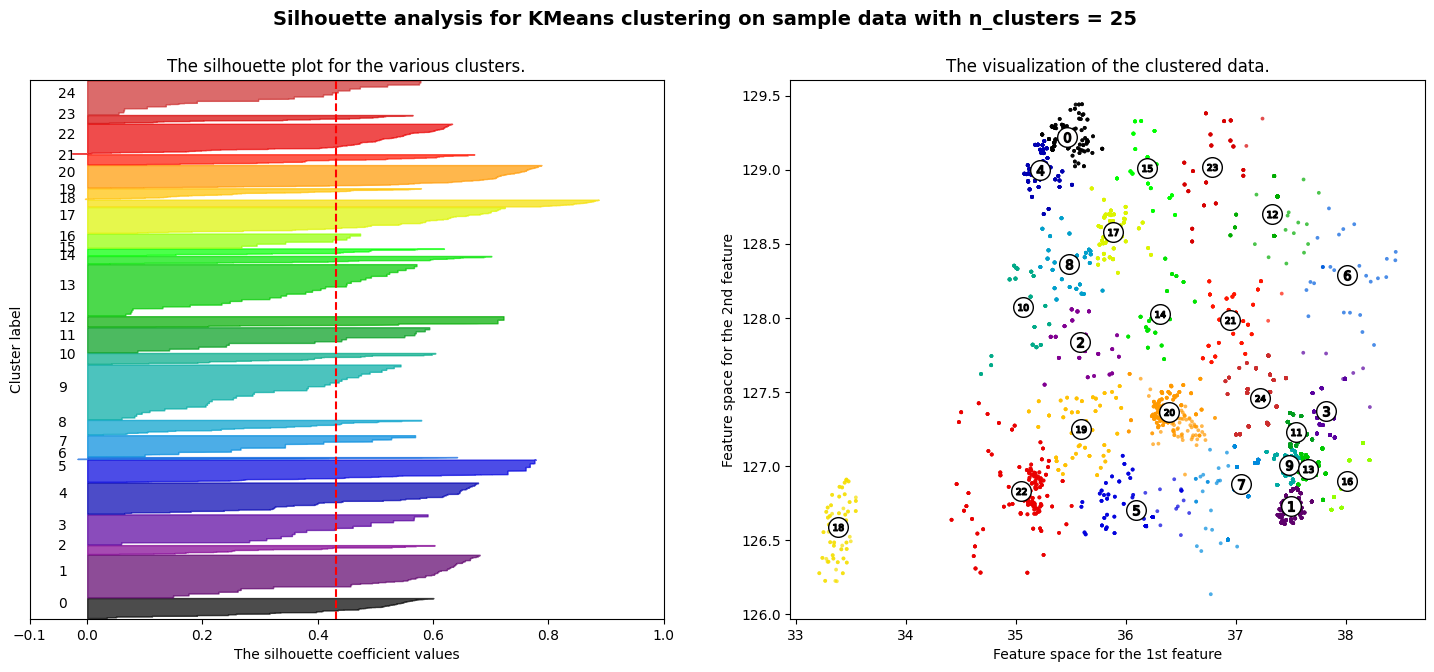

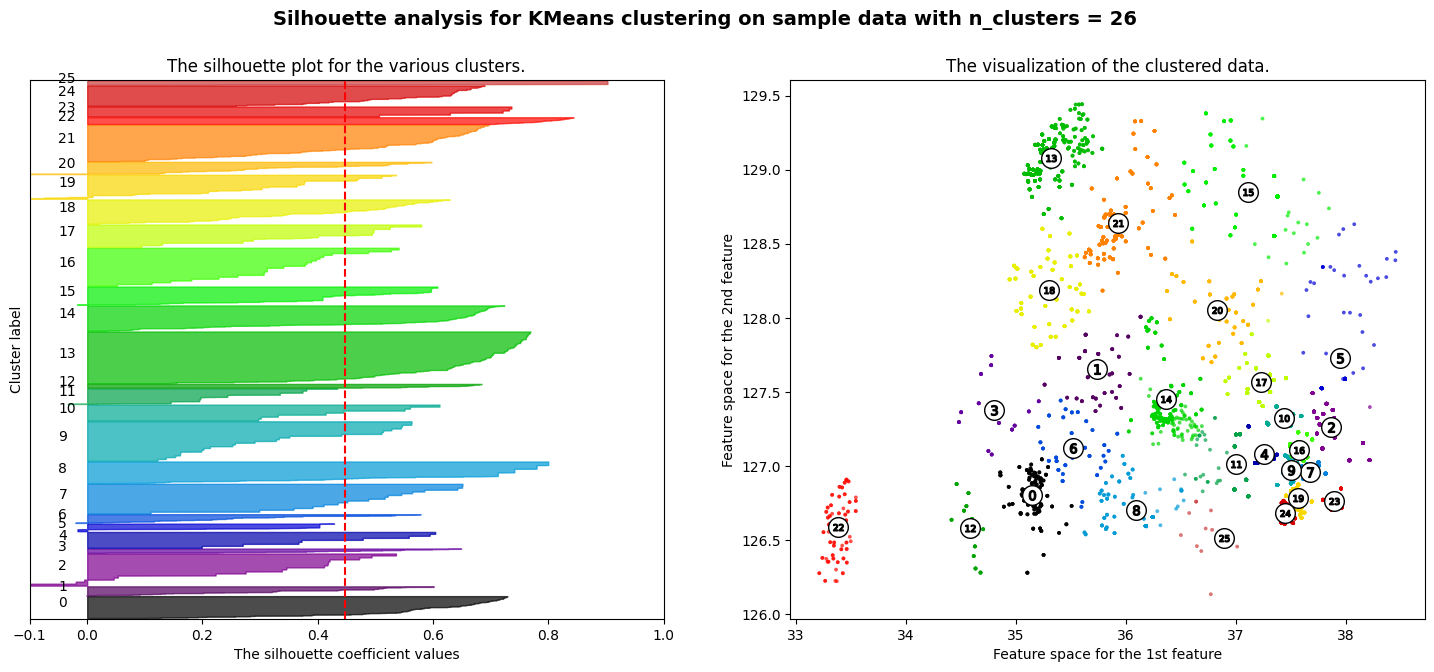

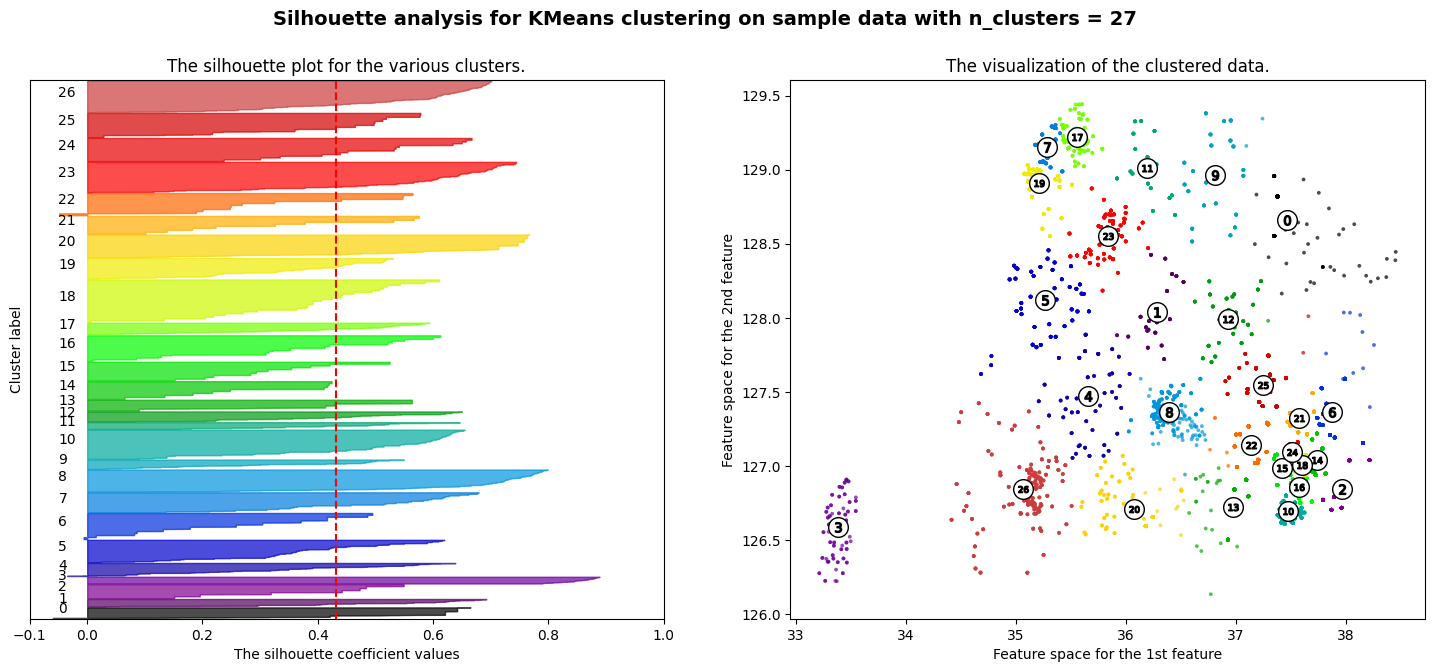

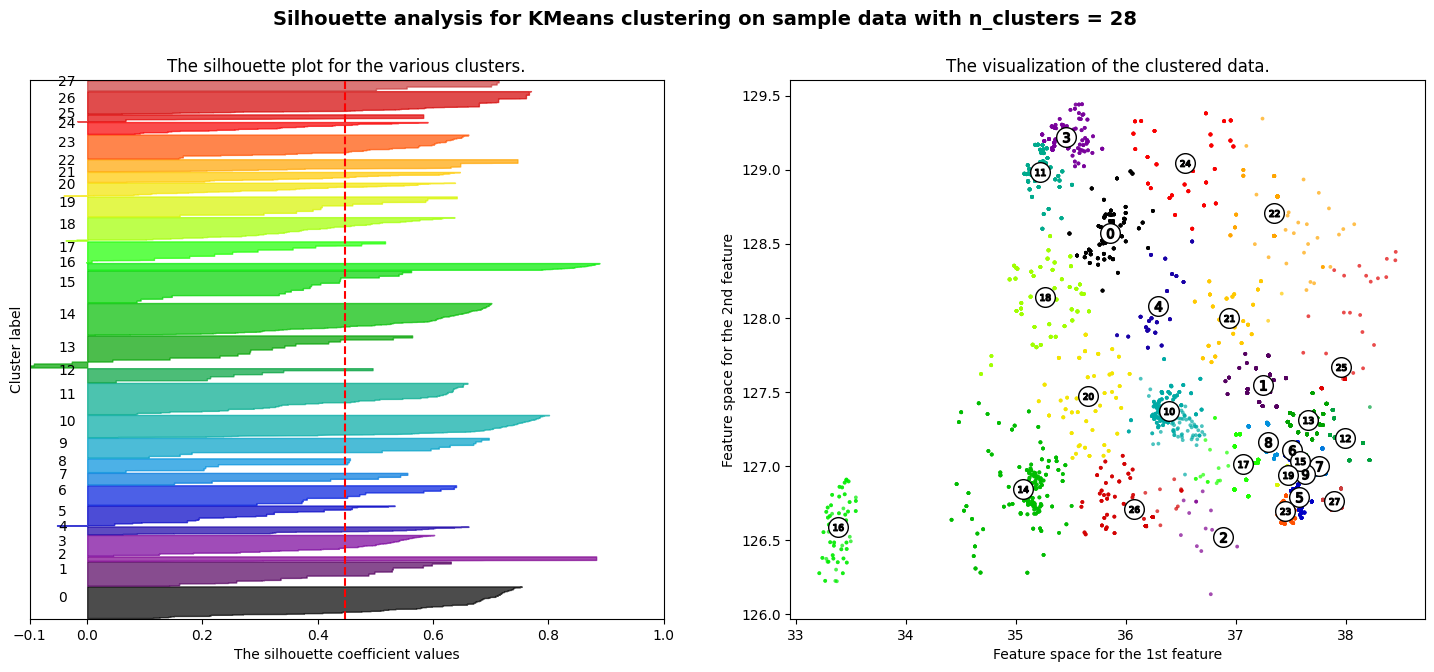

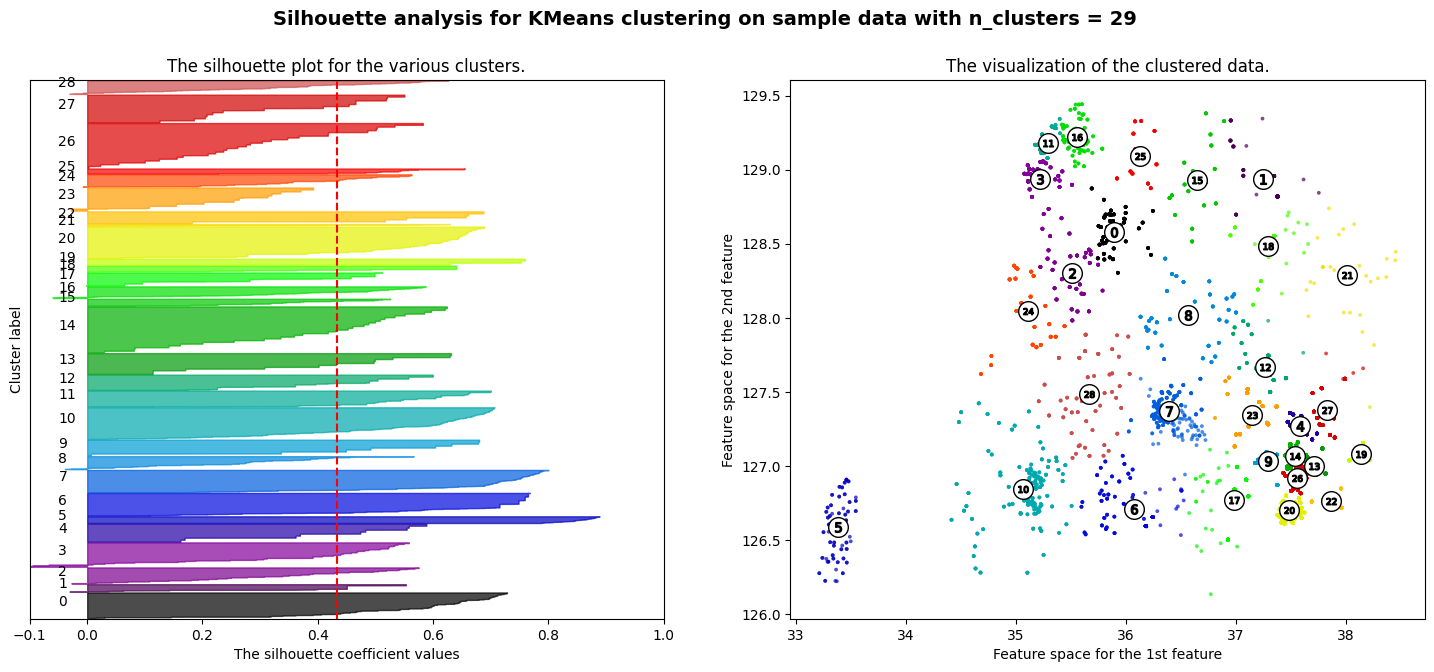

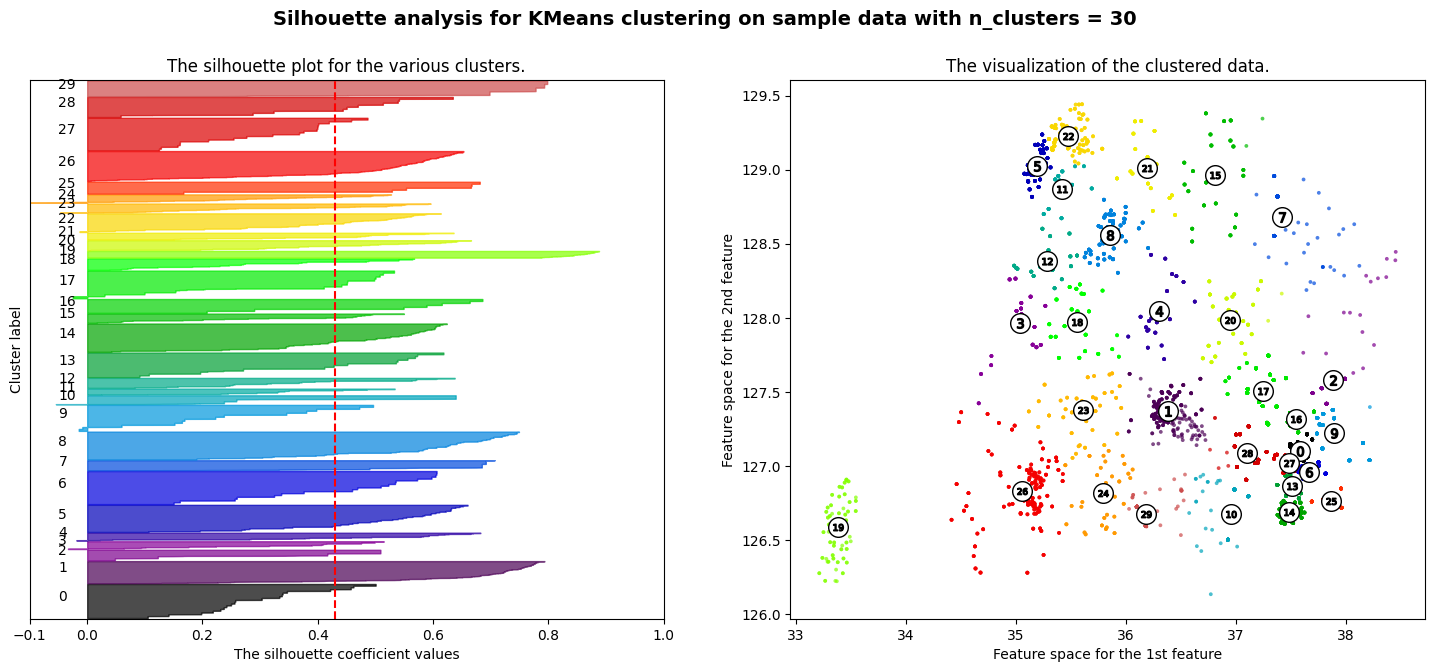

In [53]:

range_n_clusters = range(25, 31)

# 클러스터 수 범위에 대해 반복.
for n_clusters in range_n_clusters:
    # 1행 2열의 서브플롯을 생성
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # 1번째 서브플롯: 실루엣 플롯
    ax1.set_xlim([-0.1, 1])  # 실루엣 계수 값의 범위 설정
    ax1.set_ylim([0, len(coordinates) + (n_clusters + 1) * 10])  # y축 범위 설정

    # k에 따라 kmeans 알고리즘 수행
    clusters, final_centroids, iterations = kmeans(k=n_clusters, max_iter=100, initial=None, points=coordinates, tol=1e-4)

    # 실루엣 스코어를 계산
    silhouette_avg = silhouette_score(coordinates, clusters)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # 각 포인트마다의 silhouette socre 얻기 
    sample_silhouette_values = silhouette_samples(coordinates, clusters)

    y_lower = 10
    for i in range(n_clusters):
        # 클러스터 i에 속하는 샘플의 실루엣 스코어를 구하고 정렬
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # 각 클러스터 별로 색 표시
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # 각 클러스터 플롯에 클러스터 번호를 표시
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # 다음 플롯을 위한 새로운 y_lower 값을 계산
        y_lower = y_upper + 10 

    # 실루엣 플롯 제목과 레이블을 설정
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # y축 레이블/눈금을 지웁니다.
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2번째 서브플롯: 실제 클러스터 시각화
    colors = cm.nipy_spectral(clusters.astype(float) / n_clusters)
    ax2.scatter(
        coordinates[:, 0], coordinates[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # 클러스터 중심점을 흰색 원으로 표시
    ax2.scatter(
        final_centroids[:, 0],
        final_centroids[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    # 클러스터 중심점을 클러스터 번호로 레이블을 추가
    for i, c in enumerate(final_centroids):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    # 클러스터 시각화 플롯 제목과 레이블을 설정
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    # 전체 플롯 제목을 설정
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()